# Random Walks

In this notebook, we implemented a variety of random walks based on the main class `Walker`. All the random walker operates over a graph, which has nodes in a lattice configuration, and just connections to the near four neighbors are allowed (top, bottom, left, right).

In [1]:
#from google.colab import drive
#drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [16]:
#%cd /content/gdrive/MyDrive/Proyectos/aco_random_walk/

In [15]:
%cd /home/zosov/ACO_Random_Walk/
!ls

/home/zosov/ACO_Random_Walk
LICENSE  README.md  kite_tutorial.ipynb  model	notebooks  stuff  utils


In [17]:
!ls

LICENSE  README.md  kite_tutorial.ipynb  model	notebooks  stuff  utils


In [18]:
# import necessary libraries
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import enum
import numpy as np
import random
import os
import pandas as pd
from collections import Counter
import math

#own functions
import model.graph_env as ge
import utils.visualization as vis

In [19]:
DATA_DIR = "stuff/data/random_maze/"
SAVING_DIR = "stuff/results/aco_pp/"
PROXIMITIES_DIR = SAVING_DIR + "proximities/"
RANDOM_WALK_DIR = SAVING_DIR + "random_walks/"

if not os.path.exists(DATA_DIR):
  os.mkdir(DATA_DIR)

if not os.path.exists(SAVING_DIR):
  os.mkdir(SAVING_DIR)

if not os.path.exists(PROXIMITIES_DIR):
  os.mkdir(PROXIMITIES_DIR)

if not os.path.exists(RANDOM_WALK_DIR):
  os.mkdir(RANDOM_WALK_DIR)

# Base Walker class

This is the base walker class which defines the way to deposit pheromones and some basic operations.

In [23]:
def get_distance(pos1, pos2, distance):
  x1, y1 = pos1
  x2, y2 = pos2

  if distance == 'euclidean':
    result = np.sqrt((x2-x1)**2 + (y2-y1)**2)
  elif distance == 'manhattan':
    result = np.s(x2-x1) + np.abs(y2-y1)

  return result

In [24]:
class Walker():
  def __init__(self, graph, q_0 = None, reward_tau = 0.0001):
    
  
    self.graph = graph
    self.q_0 = q_0
    self.size = graph.size
    self.start_node = 0
    self.target_node = graph.size * graph.size - 1
    self.reset_walk()

  def reset_walk(self):
    self.current_path = []
    self.current_position = self.start_node
    self.visited_nodes = []

  def get_distance_path(self):
    total_distance = 0
    for node1, node2 in self.current_path:
      pos1 = self.graph.nodes[node1]['pos']
      pos2 = self.graph.nodes[node2]['pos']
      total_distance += get_distance(pos1, pos2, 'euclidean')

    return total_distance

  def end_route(self):
    return self.current_position == self.target_node


# Proximity Random Walker

This random walker is with tendency based on the proximity measure, which represents the distance from the neighbor node to the target node. In this way, the random walks follows the following decision-making algorithm in each step.

Let the node $i$, the probability of move from node $i$ to node $j$ is

$$ p_{i j}^{k}= \frac{\upsilon_{i j} }{\sum_{n_{i l} \in \mathrm{N}(s^{p})} \upsilon_{i l}}  \quad \text{if} \quad n_{ij} \in \mathbf{N}_i $$



where $\mathrm{N}_i$ is the set of feasible neighbors nodes, and $\upsilon_{ij}$ is the proximity of the neighbor node $j$ respect to the current node $i$.

In this way, the algorithm encourages to the walker to direct to the target node whereas mantains its random behavior.

### Proximity and Multiplication Step

The `proximity` represent the inverse relative distance of a neighbor node to the target node. In this section, we review the distribution of this metric in environments with different sizes. Also, we propose a **proximity 2** to reduce the sparse values. The proximity of current node $i$ respect to the neighbor node $j$ is

$$ \mathrm{proximity1}_{ij} = \frac{1}{d_{jt}} = \upsilon_{ij} $$

where $d_{jt}$ is the manhattan or euclidean distance of the neighbor node $j$ to the target node $t$.

Additionally, here we propose to multiply the previous inverse distance to $d_{it}$, the distance of the current node $i$ to the target node $t$, as

$$ \mathrm{proximity2}_{ij} = \frac{d_{it}}{d_{jt}} = \upsilon_{ij} $$



### Local and Global Normalization

In this section, we wondered if it is necessary to mantain the proximity values within of acceptable range of values. In this regard, we evaluate diverse normalization steps to a global and local level.

* `global`: applies a normalization between all the proximities values of the whole environment.
* `local`: applies a normalization in each step of the walker, or, in other words, between the proximities values of the neighbor nodes belonging to $N(n^i)$.

In order to check different normalization methods, we used:

* `standard`
* `l2-norm`
* `max-min`

In [8]:
def get_proximity(graph, current_node, neighbor_node, target_node, 
                  mode = 'proximity_1', distance = 'euclidean'):
  """
  Proximity. Calculate the proximity of the neighbor node.
  :param graph:         graph environment
  :param current_node:  index of the current node i
  :param neighbor_node: index of the neihbor node j
  :param target_node:   index of the neihbor node t
  :param mode:          perform the proximity 1 or proximity 2
  :param distance:      used distance to calculate the proximity
  """
  pos_neighbor = graph.nodes[neighbor_node]['pos']
  pos_target = graph.nodes[target_node]['pos']
  pos_current = graph.nodes[current_node]['pos']

  # distance: current node to target
  dis_curr2target = get_distance(pos_current, pos_target, distance)
  
  # distance: neighbor to target
  dis_neig2target = get_distance(pos_neighbor, pos_target, distance)
  
  if neighbor_node == target_node:
    proximity = 1
  else:

    if mode == 'proximity_1':
      proximity = 1/ dis_neig2target
    elif mode == 'proximity_2':
      proximity = dis_curr2target / dis_neig2target

  return proximity

In [9]:
def normalize_array(array, mode):
  if mode == 'standard':
    mean = np.mean(array)
    std = np.std(array)

    if std != 0.0:
      array = (array - mean) / std

  elif mode == 'l2-norm':
    array = array / np.linalg.norm(array)


  elif mode == 'max-min':
    max = np.amax(array)
    min = np.amin(array)
    if (max - min) == 0.0:
      array = np.repeat(0.5,len(array))
    else:
      array = (array - min) / (max - min)


  return array


In [10]:
#@title Function: Calculate the proximities of the total environment
def get_env_proximities(graph, 
                        normalization = None, 
                        proximity_mode = 'proximity_1', 
                        distance = 'manhattan', 
                        mode = 'global'):

  target_node = graph.size * graph.size - 1

  proximities_env = []

  for current_node in range(graph.number_of_nodes()):
    if current_node != target_node:
      neighbors = graph[current_node]

      # print("Node: ", current_node)

      tmp_proximities = []
      for neighbor_node, _ in neighbors.items():
          # get the weight per neighbor
          proximity = get_proximity(graph, 
                                      current_node,
                                      neighbor_node, 
                                      target_node,
                                      proximity_mode,
                                      distance)
          # proximities_env.append(proximity)
          tmp_proximities.append(proximity)
      
      if mode == 'local':
        tmp_proximities = normalize_array(tmp_proximities, normalization)

      proximities_env = np.concatenate((proximities_env,tmp_proximities))

  if mode == 'global':
    proximities_env = normalize_array(proximities_env, normalization)

  return proximities_env

In [11]:
def get_group_proximities(graph, mode = 'global', sub_fix = "", save = False):
  distances_options = ['euclidean', 'manhattan']
  proximities_options = ['proximity-1', 'proximity-2']
  normalization_options = ['none', 'standard', 'l2-norm', 'max-min']

  file_name = 'proximities_'
  file_name += 'size_{}_{}{}.npz'.format(graph.size,mode,sub_fix)

  data = {}

  for proxi_mode in proximities_options:
    for normalization in normalization_options:
      for distance_mode in distances_options:
        proximities_env = get_env_proximities(graph, 
                                              normalization = normalization, 
                                              proximity_mode = proxi_mode.replace('-','_'), 
                                              distance = distance_mode,
                                              mode = mode)
        
        id = "{}_{}_{}".format(proxi_mode, normalization, distance_mode)


        data[id] = proximities_env

  if save:
    outpu_dir = os.path.join(PROXIMITIES_DIR, file_name)
    np.savez(outpu_dir, **data)

  return data

In [12]:
!ls $PROXIMITIES_DIR

proximities_size_100_global.npz  proximities_size_10_local.npz
proximities_size_10_global.npz	 proximities_size_10_local_stvmax_min.npz


In [138]:
graph = ge.PPGraph(size = 10, tau_0 = 0.1)
arr_list = get_group_proximities(graph, mode='local',save = 'True')

[Load] proximities data:  stuff/results/aco_pp/proximities/proximities_size_10_local.npz


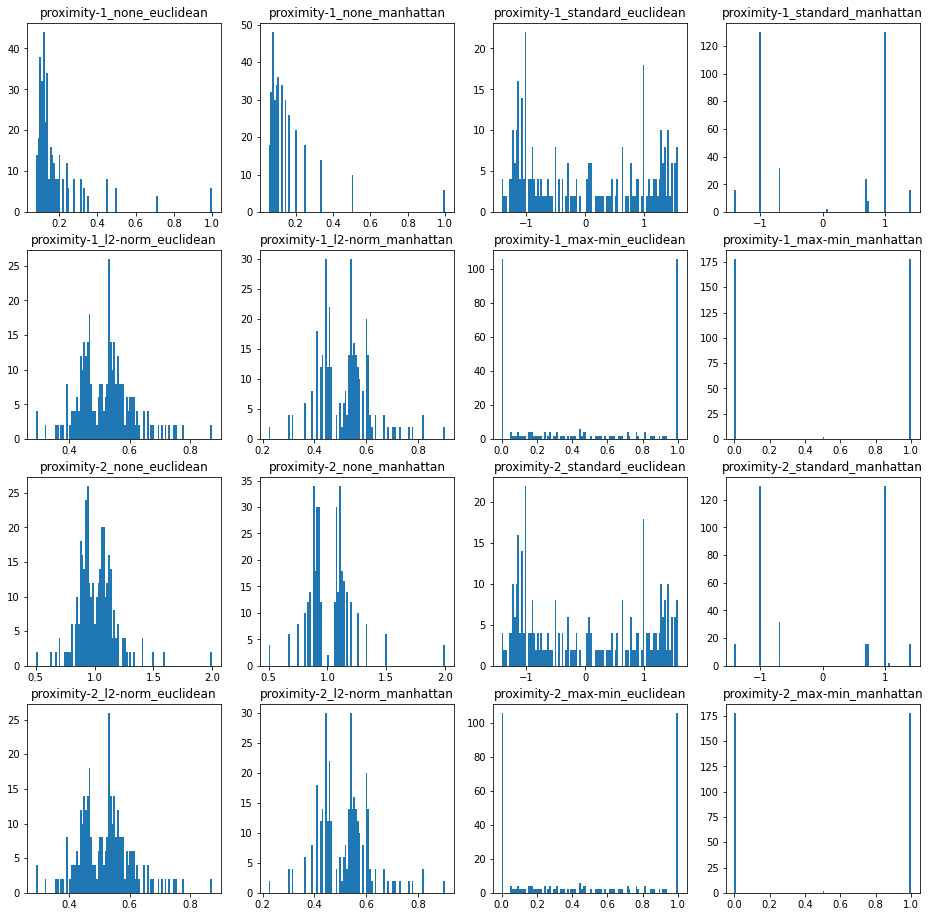

In [142]:
filename = os.path.join(PROXIMITIES_DIR,"proximities_size_10_local.npz")
vis.plot_histograms(filename=filename, bins=100)

In [140]:
graph = ge.PPGraph(size = 10, tau_0 = 0.1)
arr_list = get_group_proximities(graph, mode='global',save = 'True')

[Load] proximities data:  stuff/results/aco_pp/proximities/proximities_size_10_global.npz


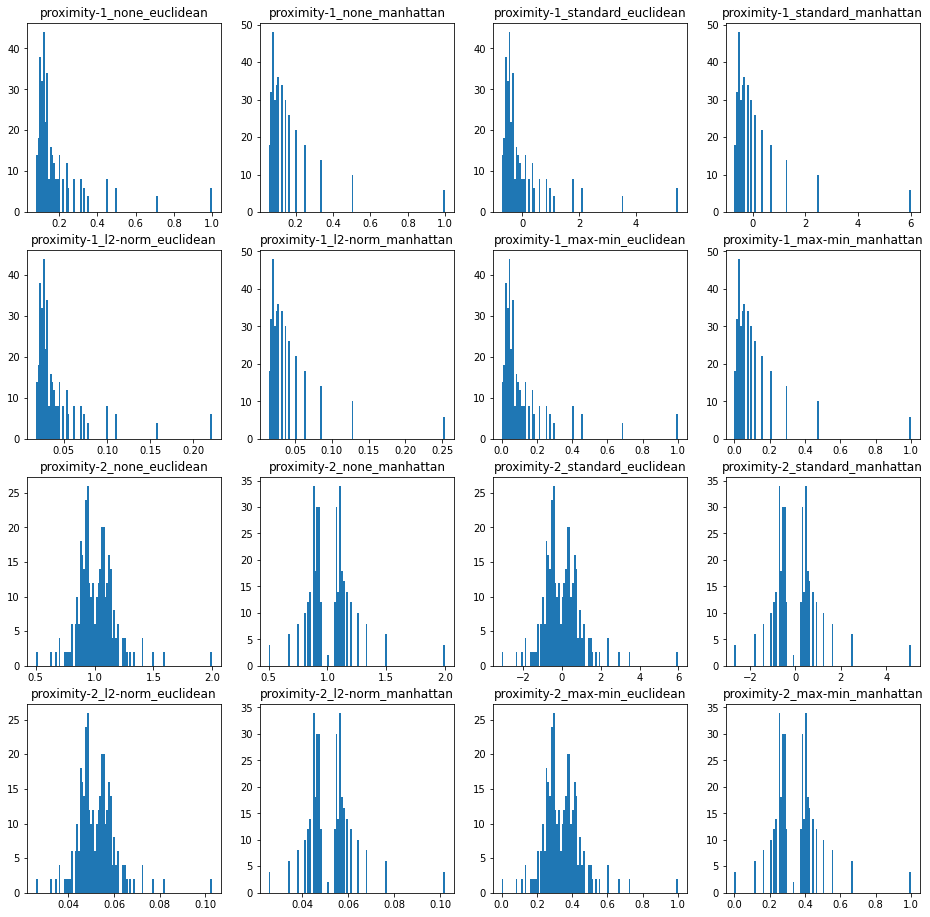

In [141]:
filename = os.path.join(PROXIMITIES_DIR,"proximities_size_10_global.npz")
vis.plot_histograms(filename=filename, bins=100)

Here according to the relevant proximities and normalization we evaluated different random walkers. Also, we decide to test only local normalization because it present more interesting variations.

In [21]:
class ProximityWalker(Walker):
  def __init__(self, graph, q_0 = None, reward_tau = 0.0001,
               proximity_mode = 'proximity_1', distance_type = 'euclidean', 
               normalization = None):
    
    self.proximity_mode = proximity_mode
    self.distance_type = distance_type
    self.normalization = normalization
    super().__init__(graph, q_0, reward_tau)


  def update_step(self):
    neighbors = self.graph[self.current_position]

    weights = []
    neighbors_idx = []
    for neighbor_node, edge in neighbors.items():
        # get the weight per neighbor
        weights.append(get_proximity(self.graph, 
                                     self.current_position,
                                     neighbor_node, 
                                     self.target_node,
                                     self.proximity_mode,
                                     self.distance_type))
        neighbors_idx.append(neighbor_node)

    # applied local normalization
    if normalization is not None:
      weights = normalize_array(weights, self.normalization)
      

    if self.q_0 is not None and np.random.rand() < self.q_0:
      new_position = neighbors_idx[np.argmax(weights)]
  
    else:
      acu_weight = sum(weights)
      probabilities = np.array(weights)/acu_weight
      #print("[INFO] probabilities: {}".format(probabilities))

      # choose an option following the wheel selection algorithm  
      new_position = random.choices(neighbors_idx, weights = probabilities)[0]
      
    self.current_path.append((self.current_position, new_position))
    self.visited_nodes.append(new_position)
    self.current_position = new_position


  def walk(self, num_rand_walks, save = False):
    # Create
    distances_list = []

    for i in range(int(num_rand_walks)):
      
      is_complete = False

      while not is_complete:
        self.update_step()

        is_complete = self.end_route()

      #print("[INFO] n_rw: {} len_path: {}".format(i, len(walker.current_path) ))
      distances_list.append(len(self.current_path))

      self.reset_walk()

    if save:
      self.saving_np_file(distances_list, num_rand_walks)
    return distances_list

  def saving_np_file(self, distances_list, num_rand_walks):
    output_dir = os.path.join(RANDOM_WALK_DIR,"rw_proximity/")
    if not os.path.exists(output_dir):
      os.mkdir(output_dir)
    filename = "rw_prox_{}_size_{}_{}_{}_{}_q0_{}.npz".format(
        num_rand_walks,
        self.graph.size,
        self.proximity_mode.replace("_","-"),
        self.distance_type,
        self.normalization,
        self.q_0
    )
    filename = os.path.join(output_dir,filename)
    print("[Saving] rw distances: ", filename)
    np.savez(filename, 
              distances = np.array(distances_list), 
              mean_std = np.array(np.mean(distances_list),np.std(distances_list)))

In [32]:
proximities_options = ['proximity_1', 'proximity_2']
distances_options = ['euclidean', 'manhattan']
normalization_options = [ 'none', 'l2-norm', 'max-min']
num_rand_walks = int(1e5)
q_0 = 0

for proximity in proximities_options:

  for distance in distances_options:

    for normalization in normalization_options:
      # Create the graph
      graph = ge.PPGraph(size = 10, tau_0 = 0.1)

      # Create the walker
      walker = ProximityWalker(graph, 
                               q_0 = q_0, 
                               reward_tau = 0.0001,
                               proximity_mode = proximity,
                               distance_type = distance,
                               normalization = normalization)

      # Perform the walk
      distances_list = walker.walk(num_rand_walks= num_rand_walks, save = True)
      print("Proximity: {} Distance: {} Normalization: {} Mean: {} Std: {}".format(
          proximity,
          distance,
          normalization,
          np.mean(distances_list),
          np.std(distances_list)))
      

[Saving] rw distances:  stuff/results/aco_pp/random_walks/rw_proximity/rw_prox_100000_size_10_proximity-1_euclidean_none_q0_0.npz
Proximity: proximity_1 Distance: euclidean Normalization: none Mean: 120.16732 Std: 74.18244269379109
[Saving] rw distances:  stuff/results/aco_pp/random_walks/rw_proximity/rw_prox_100000_size_10_proximity-1_euclidean_l2-norm_q0_0.npz
Proximity: proximity_1 Distance: euclidean Normalization: l2-norm Mean: 120.288 Std: 73.84717256605022
[Saving] rw distances:  stuff/results/aco_pp/random_walks/rw_proximity/rw_prox_100000_size_10_proximity-1_euclidean_max-min_q0_0.npz
Proximity: proximity_1 Distance: euclidean Normalization: max-min Mean: 20.74786 Std: 2.644470725948767
[Saving] rw distances:  stuff/results/aco_pp/random_walks/rw_proximity/rw_prox_100000_size_10_proximity-1_manhattan_none_q0_0.npz
Proximity: proximity_1 Distance: manhattan Normalization: none Mean: 110.78094 Std: 66.13849418240787
[Saving] rw distances:  stuff/results/aco_pp/random_walks/rw_pr

In [26]:
proximity_values = os.listdir(RANDOM_WALK_DIR + "rw_proximity")
proximity_values

['rw_prox_10_size_10_proximity-1_euclidean_none_q0_0.npz',
 'rw_prox_10_size_10_proximity-1_euclidean_l2-norm_q0_0.npz',
 'rw_prox_10_size_10_proximity-1_euclidean_max-min_q0_0.npz',
 'rw_prox_10_size_10_proximity-1_manhattan_none_q0_0.npz',
 'rw_prox_10_size_10_proximity-1_manhattan_l2-norm_q0_0.npz',
 'rw_prox_10_size_10_proximity-1_manhattan_max-min_q0_0.npz',
 'rw_prox_10_size_10_proximity-2_euclidean_none_q0_0.npz',
 'rw_prox_10_size_10_proximity-2_euclidean_l2-norm_q0_0.npz',
 'rw_prox_10_size_10_proximity-2_euclidean_max-min_q0_0.npz',
 'rw_prox_10_size_10_proximity-2_manhattan_none_q0_0.npz',
 'rw_prox_10_size_10_proximity-2_manhattan_l2-norm_q0_0.npz',
 'rw_prox_10_size_10_proximity-2_manhattan_max-min_q0_0.npz']

In [28]:
dict_arrays = {}
for file_npz in proximity_values:
  proximity_type = file_npz.split("_")[5]
  distance_type = file_npz.split("_")[6]
  normalization_type = file_npz.split("_")[7]
  q0_value = file_npz.split("_")[9]

  id_name = "{} {} {} {}".format(
      proximity_type,
      distance_type,
      normalization_type,
      "q_0: " + q0_value
  )
  file_name = os.path.join(RANDOM_WALK_DIR + "rw_proximity",file_npz)
  dict_arrays[id_name] = np.load(file_name)['distances']

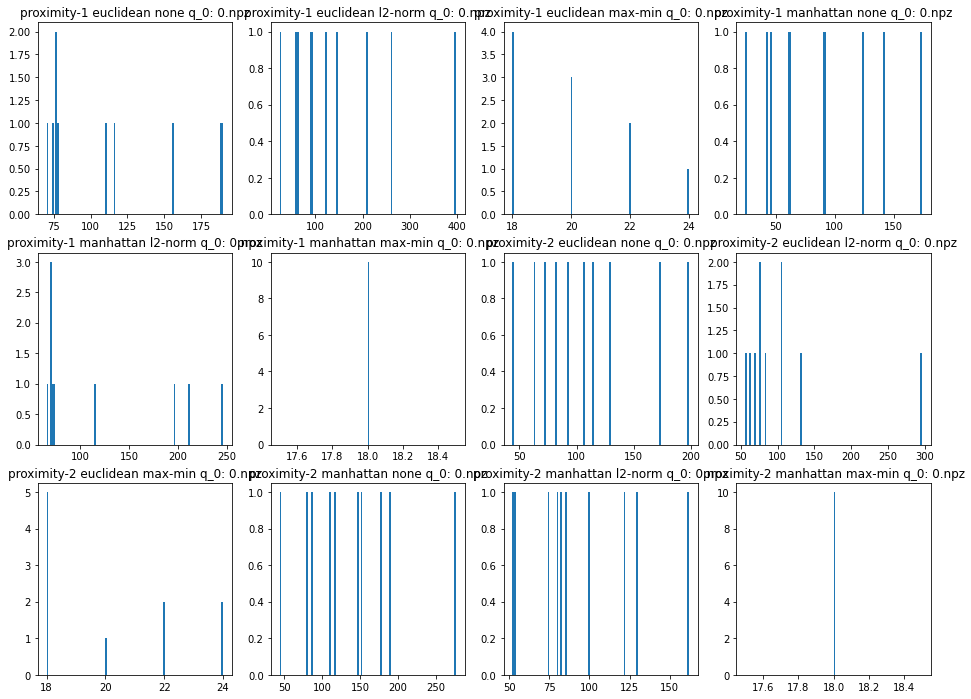

In [30]:
vis.plot_histograms(dict_arrays,100)

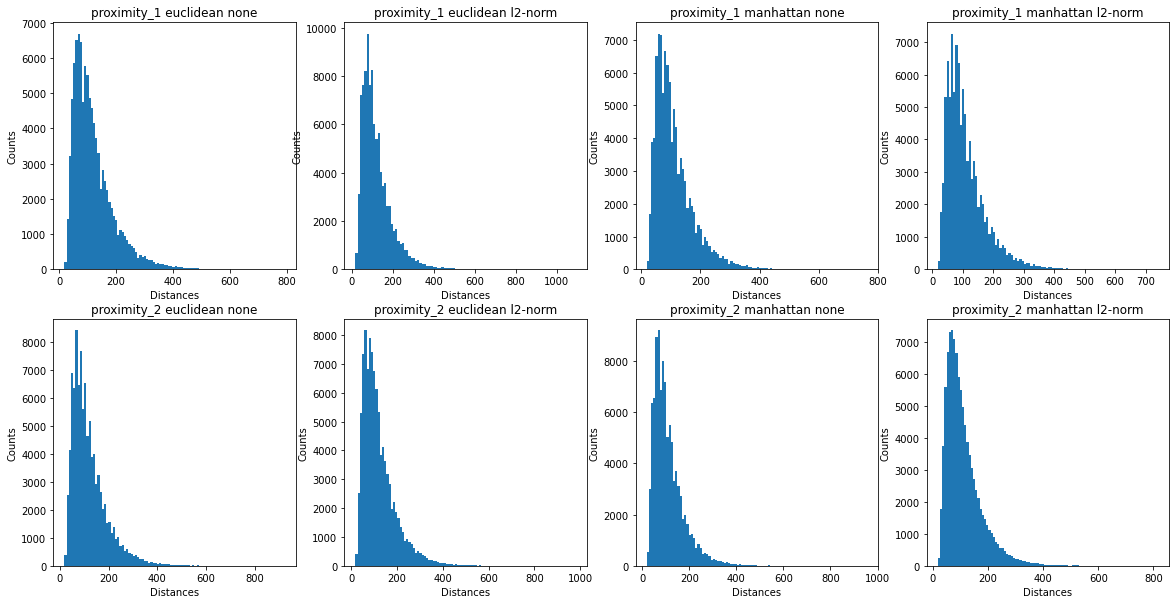

In [ ]:
rows = len(proximities_options)
cols = len(distances_options) * len(normalization_options)
inches = 5
fig, axs = plt.subplots(rows, cols , figsize = (cols * inches, rows * inches))

for i, proximity in enumerate(proximities_options):
  j = 0
  for distance in distances_options:
    for normalization in normalization_options:
      axs[i,j].hist(mul_distances_list[proximity][distance][normalization], bins=100)
      axs[i,j].set_xlabel ("Distances")
      axs[i,j].set_ylabel("Counts")
      #title = "Random Walk Distances Distribution\n"
      title = "{} {} {}".format(proximity,distance, normalization)
      axs[i,j].set_title(title)
      j += 1

In [ ]:
q_0_options = [0.3, 0.5, 0.7, 0.9]
proximity_type = "proximity_2"
distance_type = "manhattan"

def plot_distribution_q_0(q_0_options, proximity_type, distance_type):
  rows = 1
  cols = len(q_0_options)
  inches = 5
  fig, axs = plt.subplots(rows, cols) #, figsize = (cols * inches, rows * inches))

  for i, q_0 in enumerate(q_0_options):
    # Create the graph
    graph = PPGraph(size = 10, tau_0 = 0.1)

    # Create the walker
    walker = Walker(graph, reward_tau = 0.0001, q_0 = q_0)

    # Perform the walk
    distances_list = walker.walk(num_rand_walks= 1e5,
                                proximity_mode = proximity_type,
                                distance_type =  distance_type,
                                normalization = None)
    print("Proximity: {} Distance: {} Normalization: {} Mean: {} Std: {}".format(
        proximity,
        distance,
        normalization,
        np.mean(distances_list),
        np.std(distances_list)))
    
    axs[i].hist(distances_list, bins=100)
    axs[i].set_xlabel ("Distances")
    axs[i].set_ylabel("Counts")
    #title = "Random Walk Distances Distribution\n"
    title = "{} {} {} q_0: {}".format(proximity_type, distance_type, normalization, q_0)
    axs[i].set_title(title)
    

Proximity: proximity_2 Distance: manhattan Normalization: l2-norm Mean: 43.03222 Std: 14.521550945804654
Proximity: proximity_2 Distance: manhattan Normalization: l2-norm Mean: 30.5996 Std: 7.714842826655642
Proximity: proximity_2 Distance: manhattan Normalization: l2-norm Mean: 23.8375 Std: 4.261656221470709
Proximity: proximity_2 Distance: manhattan Normalization: l2-norm Mean: 19.58768 Std: 1.9055687386184732


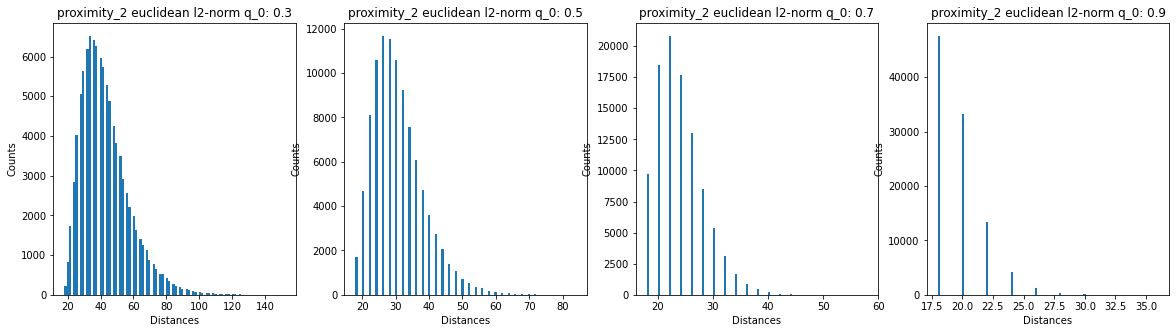

In [ ]:
q_0_options = [0.3, 0.5, 0.7, 0.9]
proximity_type = "proximity_2"
distance_type = "euclidean"

rows = 1
cols = len(q_0_options)
inches = 5
fig, axs = plt.subplots(rows, cols , figsize = (cols * inches, rows * inches))

for i, q_0 in enumerate(q_0_options):
  # Create the graph
  graph = PPGraph(size = 10, tau_0 = 0.1)

  # Create the walker
  walker = Walker(graph, reward_tau = 0.0001, q_0 = q_0)

  # Perform the walk
  distances_list = walker.walk(num_rand_walks= 1e5,
                              proximity_mode = proximity_type,
                              distance_type =  distance_type,
                              normalization = None)
  print("Proximity: {} Distance: {} Normalization: {} Mean: {} Std: {}".format(
      proximity,
      distance,
      normalization,
      np.mean(distances_list),
      np.std(distances_list)))
  
  axs[i].hist(distances_list, bins=100)
  axs[i].set_xlabel ("Distances")
  axs[i].set_ylabel("Counts")
  #title = "Random Walk Distances Distribution\n"
  title = "{} {} {} q_0: {}".format(proximity_type, distance_type, normalization, q_0)
  axs[i].set_title(title)
  

In [ ]:
arr = [1, 3, 2, 2]
winner = np.argwhere(arr == np.amax(arr))

np.random.choice(winner.flatten(), 1)[0]

1

1. proximidad + q_0 + levy flight 
2. greedy + q_0 + levy flight



In [183]:
class GreedyWalker(Walker):
  def __init__(self, graph, q_0 = None, reward_tau = 0.0001, advantage = 3):

    self.advantage = advantage
    super().__init__(graph, q_0, reward_tau)

  def get_greedy_favorites(self, location = ('bottom','right') ):
    
    favorites_nodes = []
    if location[1] == 'right':
      favorites_nodes.append(self.current_position + 1)
    elif location[1] == 'left':
      favorites_nodes.append(self.current_position - 1)

    if location[0] == 'bottom':
      favorites_nodes.append(self.current_position + self.size)
    elif location[0] == 'top':
      favorites_nodes.append(self.current_position - self.size)

    return favorites_nodes

  def update_step(self):
    neighbors = self.graph[self.current_position]

    neighbors_idx = [n for n, edge in neighbors.items()]
    favorites = self.get_greedy_favorites()
    weights = [ self.advantage if n in favorites else 1 for n in neighbors_idx ]


    if self.q_0 is not None and np.random.rand() < self.q_0:
      new_position = neighbors_idx[np.argmax(weights)]
      # arg_max = np.argwhere(weights == np.amax(weights))
      # new_position = np.random.choice(arg_max.flatten(), 1)[0]
  
    else:
      acu_weight = sum(weights)
      probabilities = np.array(weights)/acu_weight
      # print("[INFO] curren_node: {} nodes: \t {}".format(self.current_position, neighbors_idx))
      # print("[INFO] probabilities: \t {}".format(probabilities))

      # choose an option following the wheel selection algorithm 
      new_position = random.choices(neighbors_idx, weights = probabilities)[0]
      
    self.current_path.append((self.current_position, new_position))
    self.visited_nodes.append(new_position)
    self.current_position = new_position

  def walk(self, num_rand_walks, save = False):
    # Create
    distances_list = []

    for i in range(int(num_rand_walks)):
      
      is_complete = False

      while not is_complete:
        self.update_step()

        is_complete = self.end_route()

      #print("[INFO] n_rw: {} len_path: {}".format(i, len(walker.current_path) ))
      distances_list.append(len(self.current_path))

      self.reset_walk()

    if save:
      self.saving_np_file(distances_list, num_rand_walks)


    return distances_list

  def saving_np_file(self, distances_list, num_rand_walks):
    output_dir = os.path.join(RANDOM_WALK_DIR,"rw_greedy/")
    if not os.path.exists(output_dir):
      os.mkdir(output_dir)
    filename = "rw_greedy_{}_size_{}_adv_{}_q0_{}.npz".format(
        num_rand_walks,
        self.graph.size,
        self.advantage,
        self.q_0
    )
    filename = os.path.join(output_dir,filename)
    print("[Saving] rw distances: ", filename)
    np.savez(filename, 
              distances = np.array(distances_list), 
              mean_std = np.array(np.mean(distances_list),np.std(distances_list)))

In [184]:
advantage_options = [2,2.5,3]
q_0_options = [0, 0.3, 0.5, 0.7, 0.9]
num_rand_walks = 10

for advantage in advantage_options:
  for q_0 in q_0_options:
    # Create the graph
    graph = ge.PPGraph(size=10, tau_0=0.1)

    # Create the walker
    walker = GreedyWalker(graph, 
                          q_0 = q_0, 
                          reward_tau = 0.0001, 
                          advantage = advantage)
    
    # Perform the walk
    distances_list = walker.walk(num_rand_walks, save = True)
    print("advantage: {} q_0: {} Mean: {} Std: {}".format(
        advantage,
        q_0,
        np.mean(distances_list),
        np.std(distances_list)))

[Saving] rw distances:  stuff/results/aco_pp/random_walks/rw_greedy/rw_greedy_10_size_10_adv_2_q0_0.npz
advantage: 2 q_0: 0 Mean: 51.8 Std: 17.284675293449975
[Saving] rw distances:  stuff/results/aco_pp/random_walks/rw_greedy/rw_greedy_10_size_10_adv_2_q0_0.3.npz
advantage: 2 q_0: 0.3 Mean: 30.0 Std: 4.8166378315169185
[Saving] rw distances:  stuff/results/aco_pp/random_walks/rw_greedy/rw_greedy_10_size_10_adv_2_q0_0.5.npz
advantage: 2 q_0: 0.5 Mean: 26.6 Std: 5.295280917949491
[Saving] rw distances:  stuff/results/aco_pp/random_walks/rw_greedy/rw_greedy_10_size_10_adv_2_q0_0.7.npz
advantage: 2 q_0: 0.7 Mean: 23.2 Std: 3.4871191548325386
[Saving] rw distances:  stuff/results/aco_pp/random_walks/rw_greedy/rw_greedy_10_size_10_adv_2_q0_0.9.npz
advantage: 2 q_0: 0.9 Mean: 18.8 Std: 1.32664991614216
[Saving] rw distances:  stuff/results/aco_pp/random_walks/rw_greedy/rw_greedy_10_size_10_adv_2.5_q0_0.npz
advantage: 2.5 q_0: 0 Mean: 37.8 Std: 9.61041102138717
[Saving] rw distances:  stuff/r

In [ ]:
def plot_distribution_q_0(q_0_options, num_rand_walks):
  rows = 1
  cols = len(q_0_options)
  inches = 5
  fig, axs = plt.subplots(rows, cols, figsize = (cols * inches, rows * inches))

  for i, q_0 in enumerate(q_0_options):
    # Create the graph
    graph = PPGraph(size = 10, tau_0 = 0.1)

    # Create the walker
    walker = WalkerLeftBottom(graph, reward_tau = 0.0001, q_0 = q_0)

    # Perform the walk
    distances_list = walker.walk(num_rand_walks= num_rand_walks, advantage = 2)
    print("RightBottom - Mean: {} Std: {}".format(
        np.mean(distances_list),
        np.std(distances_list)))
    
    axs[i].hist(distances_list, bins=100)
    axs[i].set_xlabel ("Distances")
    axs[i].set_ylabel("Counts")
    #title = "Random Walk Distances Distribution\n"
    title = "{} q_0: {}".format("LeftRight", q_0)
    axs[i].set_title(title)
    

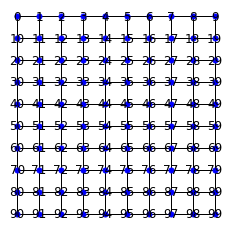

In [ ]:
graph = PPGraph(10, 1)
graph.draw_graph(with_labels=True)

LeftRight - Mean: 59.05012 Std: 25.74178175623436
LeftRight - Mean: 35.90736 Std: 10.78053699174582
LeftRight - Mean: 28.0794 Std: 6.466202567195062
LeftRight - Mean: 22.8669 Std: 3.777645349950151
LeftRight - Mean: 19.32122 Std: 1.7271993838581576


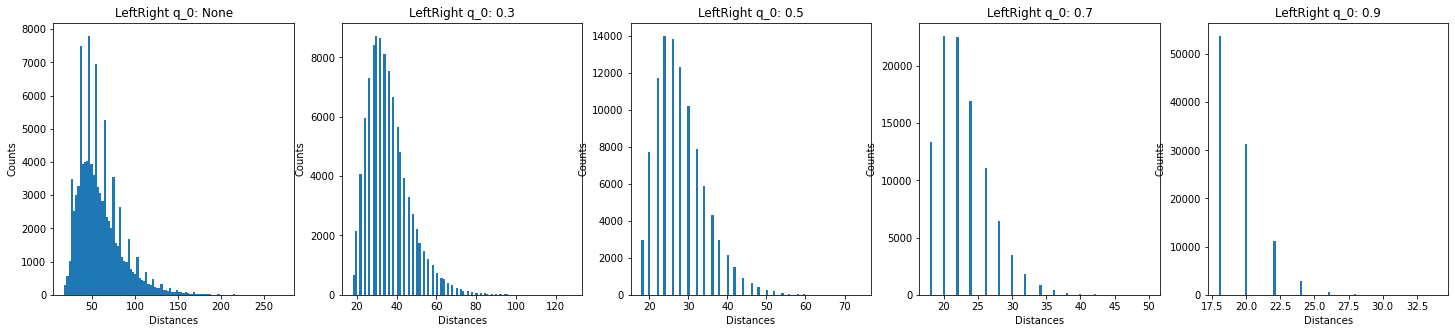

In [ ]:
q_0_options = [None, 0.3, 0.5, 0.7, 0.9]

plot_distribution_q_0(q_0_options, num_rand_walks = 1e5)


In [174]:
class LevyFlightGreedyWalker(GreedyWalker):
  def __init__(self, graph, q_0 = None, reward_tau = 0.0001, omega = 2, advantage = 3):
    # omega clustering exponent

    self.omega = omega # [1-3]

    super().__init__(graph, q_0, reward_tau, advantage)

  def wrapper_update_step(self):

    # get the neighbors of the current node
    neighbors = self.graph[self.current_position]
    neighbors_idx = [n for n, edge in neighbors.items()]

    # build a list with the possible long range connections
    # here we do not included the neighbors nor the start node
    # or target node
    pos_connections = [ n for n in np.arange(self.start_node + 1, self.target_node) if n not in neighbors_idx]

    long_range_node = random.choices(pos_connections)[0]

    dist_current2long_range = get_distance(self.graph.nodes[long_range_node]['pos'],
                                           self.graph.nodes[self.current_position]['pos'],
                                           'euclidean')

    if np.random.rand() < dist_current2long_range ** (- self.omega):
      new_position = long_range_node
      self.current_path.append((self.current_position, new_position))
      self.visited_nodes.append(new_position)
      self.current_position = new_position
    else:
      self.update_step()

  def walk(self, num_rand_walks, save = False):
    # Create
    distances_list = []

    for i in range(int(num_rand_walks)):
      
      is_complete = False

      while not is_complete:
        self.wrapper_update_step()

        is_complete = self.end_route()

      #print("[INFO] n_rw: {} len_path: {}".format(i, len(walker.current_path) ))
      distances_list.append(self.get_distance_path())

      self.reset_walk()

    if save:
      self.saving_np_file(distances_list, num_rand_walks)
    return distances_list

  def saving_np_file(self, distances_list, num_rand_walks):
    output_dir = os.path.join(RANDOM_WALK_DIR,"rw_levy_greedy/")
    if not os.path.exists(output_dir):
      os.mkdir(output_dir)
    filename = "rw_levy_greedy_{}_size_{}_omega_{}_adv_{}_q0_{}.npz".format(
        num_rand_walks,
        self.graph.size,
        self.omega,
        self.advantage,
        self.q_0
    )
    filename = os.path.join(output_dir,filename)
    print("[Saving] rw distances: ", filename)
    np.savez(filename, 
              distances = np.array(distances_list), 
              mean_std = np.array(np.mean(distances_list),np.std(distances_list)))

In [176]:
advantage_options = [2,2.5,3]
omega_options = [2,3]
q_0_options = [0, 0.3, 0.5, 0.7, 0.9]
num_rand_walks = 10

for advantage in advantage_options:
  for omega in omega_options:
    for q_0 in q_0_options:
      # Create the graph
      graph = ge.PPGraph(size=10, tau_0=0.1)

      # Create the walker
      walker = LevyFlightGreedyWalker(graph, 
                                      q_0 = q_0, 
                                      reward_tau = 0.0001, 
                                      omega = omega, 
                                      advantage = advantage)
     
      # Perform the walk
      distances_list = walker.walk(num_rand_walks, save = True)
      print("advantage: {} omega: {} q_0: {} Mean: {} Std: {}".format(
          advantage,
          omega,
          q_0,
          np.mean(distances_list),
          np.std(distances_list)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in double_scalars


[Saving] rw distances:  stuff/results/aco_pp/random_walks/rw_levy_greedy/rw_levy_greedy_10_size_10_omega_2_adv_2_q0_0.npz
advantage: 2 omega: 2 q_0: 0 Mean: 135.3548776601403 Std: 92.95852732227272
[Saving] rw distances:  stuff/results/aco_pp/random_walks/rw_levy_greedy/rw_levy_greedy_10_size_10_omega_2_adv_2_q0_0.3.npz
advantage: 2 omega: 2 q_0: 0.3 Mean: 27.902150348463636 Std: 7.196069873845758
[Saving] rw distances:  stuff/results/aco_pp/random_walks/rw_levy_greedy/rw_levy_greedy_10_size_10_omega_2_adv_2_q0_0.5.npz
advantage: 2 omega: 2 q_0: 0.5 Mean: 32.3369803153774 Std: 10.365556087918494
[Saving] rw distances:  stuff/results/aco_pp/random_walks/rw_levy_greedy/rw_levy_greedy_10_size_10_omega_2_adv_2_q0_0.7.npz
advantage: 2 omega: 2 q_0: 0.7 Mean: 30.049683694842066 Std: 11.314856726891358
[Saving] rw distances:  stuff/results/aco_pp/random_walks/rw_levy_greedy/rw_levy_greedy_10_size_10_omega_2_adv_2_q0_0.9.npz
advantage: 2 omega: 2 q_0: 0.9 Mean: 27.55998858348728 Std: 11.501172

In [154]:
class WalkerLevyFlightLB(Walker):
  def __init__(self, graph, q_0 = None, omega = 2, reward_tau = 0.0001):
    # omega clustering exponent

    self.omega = omega

    super().__init__(graph, q_0, reward_tau)

  def get_left_right(self):
    return [self.current_position + 1, self.current_position + self.size]

  def update_step(self, advantage = 3):
    neighbors = self.graph[self.current_position]

    neighbors_idx = [n for n, edge in neighbors.items()]

    # the possible long_range connection are all except the neighbors
    # or the start and target nodes
    pos_connections = [ n if n not in neighbors_idx for n in np.arange(self.start_node + 1, self.target_node)]

    long_range_node = random.choices(pos_connections)[0]

    dist_current2long_range = get_distance(self.graph.nodes[long_range_node]['pos'],
                                           self.graph.nodes[self.current_position]['pos'])

    if np.random.rand() < dist_current2long_range ** (- self.omega):
      new_position = long_range_node
    else:
      l_r = self.get_left_right()
      weights = [ advantage if n in l_r else 1 for n in neighbors_idx ]


      if self.q_0 is not None and np.random.rand() < self.q_0:
        new_position = neighbors_idx[np.argmax(weights)]
        # arg_max = np.argwhere(weights == np.amax(weights))
        # new_position = np.random.choice(arg_max.flatten(), 1)[0]
    
      else:
        acu_weight = sum(weights)
        probabilities = np.array(weights)/acu_weight
        # print("[INFO] curren_node: {} nodes: \t {}".format(self.current_position, neighbors_idx))
        # print("[INFO] probabilities: \t {}".format(probabilities))

        # choose an option following the wheel selection algorithm 
        new_position = random.choices(neighbors_idx, weights = probabilities)[0]
      
    self.current_path.append((self.current_position, new_position))
    self.visited_nodes.append(new_position)
    self.current_position = new_position

  def walk(self, num_rand_walks, advantage = 3):
    # Create
    distances_list = []

    for i in range(int(num_rand_walks)):
      
      is_complete = False

      while not is_complete:
        self.update_step(advantage)

        is_complete = self.end_route()

      #print("[INFO] n_rw: {} len_path: {}".format(i, len(walker.current_path) ))
      distances_list.append(self.get_distance_path())

      self.reset_walk()

    return distances_list

SyntaxError: ignored

Uno de los problemas sobresalientes en problemas de decision es la cantidad de estados presentes y las posibles acciones. Cuando este numero empieza a subir mucho, los algoritmos empiezan a subir problemas [consultar]. Es una area muy estudiada ttatatatat . En el presente paper se pretende estudiar este comportamiento mediante una aplicacion muestra o un escenario de juguete en donde se puede compreder de manera experimental la difficultad de alcanzar valores optimos cuando el numero de estados crece y las acciones posibles se limitan. En este caso particular se utilizo un ACO para demostrar nuestra hypothesis, que puede ser considerado a breves rasgos como un RL algorimo por su esencia de refuerzo y tal tal. Sin embargo, se pretende que sea el pilas esencial para un investigacion mas profunda de este estilo.  

1. Uno de los problemas con este tipo de algoritmos parece ser la cantidad de estados que empieza a elevarse. En un ambiente libre de obstaculos resulta sencillo resolver el problema. Sin embargo a medida que se aumentan los estados y los obstaculos presentes en el ambiente el algoritmo empieza a fallar. Existen ciertas metodo que resuelven el problema desde diferentes escenarios como algoritmos por REFUERZO, .. .. .. . En este paper, la idea es implementar cierta inicializacion de fermonas con el objetivo de superar este problema. Aunque el paper abordara un problema de combinacion bastante fundamental. El paper pretende servir como un fundamento para emplear estas mismas ideas en escenarios más complejos.

Hipotesis: proveer al algoritmo de cierto informacion (conocimiento) inicial por medio de la inicialización de fermonos siguiendo random walks. De cierta manera se espera que los random walks logren lidiar con el problema de estados y obstaculos y a su vez mejorar los tiempos de convergencia de los escenerios ya estudiados.

En general, el presente proyecto intenta abordar el problema de planificacion de ruta o path finding. Sin embargo, se podria escalar la inicializacion por random walks a escenarios más complejos e incluso a otros enfoques como algoritmos de reinforcement learning cuya esencia es optimizar la recompensa futura in a long term. Esta en escencia relacionado al algoritmo ACO por el refuerzo que recibe de las fermonos. Sin embargo, RL algoritmos implementan algoritmos más robustos.

Estudiarlo con algoritmos de refuerzo mas actuales, mas robustos donde exista cierta información suycente (como las fermonas en este caso) que aceleren el aprendizaje. Sin embargo, no necesariamente se buscaria alterar las recompensas en dichos algoritmos, ya que su actualización romperia la esencia de un algoritmo por refuerzo.